In [1]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import save,load

# librosa is a Python library for analyzing audio and music.
# It can be used to extract the data from the audio files we will see it later
import librosa 
import librosa.display

# to play the audio files
from IPython.display import Audio
plt.style.use('seaborn-white')

from optparse import OptionParser

import tensorflow as tf
from keras.layers import Input, Dense, Masking, Dropout, LSTM, Bidirectional, Activation
from keras.layers.merge import dot
from keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import backend as k

from sklearn.model_selection import train_test_split

from hyperas import optim
from hyperopt import Trials, tpe
from hyperopt import STATUS_OK
from hyperas.distributions import choice

import sys
import numpy as np
from scipy import stats
from keras.preprocessing import sequence
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Data Load

In [2]:
# Read given audio file's path and respective emotion from the file name and create a dataframe
def read_audio_data(data_dir, aud_src_list):
    columns = []
    for aud_dir in aud_src_list:
        
        # Read CREMA-D audio files        
        if aud_dir == 'CREMA_D':
            file_path = data_dir+'/'+aud_dir
            files = os.listdir(file_path)
            for file in files: 
                part = file.split('_')   
                path = ''
                if part[2] == 'SAD':
                    emotion = 'sad'
                elif part[2] == 'ANG':
                    emotion = 'angry'
                elif part[2] == 'DIS':
                    emotion = 'disgust'
                elif part[2] == 'FEA':
                    emotion = 'fear'
                elif part[2] == 'HAP':
                    emotion = 'happy'
                elif part[2] == 'NEU':
                    emotion = 'neutral'  
                else:
                    emotion = 'unknown'

                path = file_path+'/'+file
                columns.append([emotion, path])
        
        # Read SAVEE audio files
        if aud_dir == 'SAVEE':
            file_path = data_dir+'/'+aud_dir
            files = os.listdir(file_path)

            for file in files:
                path = ''
                if file[-8:-6]=='_a':
                    emotion = 'angry'
                elif file[-8:-6]=='_d':
                    emotion = 'disgust'
                elif file[-8:-6]=='_f':
                    emotion = 'fear'
                elif file[-8:-6]=='_h':
                    emotion = 'happy'
                elif file[-8:-6]=='_n':
                    emotion = 'neutral'
                elif file[-8:-6]=='sa':
                    emotion = 'sad'
                elif file[-8:-6]=='su':
                    emotion = 'surprise'
                else:
                    emotion  = 'unknown'
                path = file_path+'/'+file
                columns.append([emotion, path])
        
        # Read TESS audio files
        if aud_dir == 'TESS':
            file_path = data_dir+'/'+aud_dir
            files = os.listdir(file_path)

            for file in files:
                fname = os.listdir(file_path +'/'+ file)   
                for f in fname:
                    path = ''
                    if file == 'OAF_angry' or file == 'YAF_angry':
                        emotion = 'angry'
                    elif file == 'OAF_disgust' or file == 'YAF_disgust':
                        emotion = 'disgust'
                    elif file == 'OAF_Fear' or file == 'YAF_fear':
                        emotion = 'fear'
                    elif file == 'OAF_happy' or file == 'YAF_happy':
                        emotion = 'happy'
                    elif file == 'OAF_neutral' or file == 'YAF_neutral':
                        emotion = 'neutral'                               
                    elif file == 'OAF_Pleasant_surprise' or file == 'YAF_pleasant_surprised':
                        emotion = 'surprise'              
                    elif file == 'OAF_Sad' or file == 'YAF_sad':
                        emotion = 'sad'
                    else:
                        emotion = 'Unknown'
                    path = file_path+'/'+file+'/'+f
                    columns.append([emotion, path])
        
        # Read RAVDESS audio files
        if aud_dir == 'RAVDESS':
            file_path = data_dir+'/'+aud_dir
            actors = os.listdir(file_path)
            for actor in actors:
                files = os.listdir(file_path +'/'+ actor)

                for file in files: 
                    part = file.split('.')[0]
                    part = part.split("-")           

                    temp = int(part[6])
                    path=''

                    if part[2] == '01':
                        emotion = 'neutral'
                    elif part[2] == '02':
                        emotion = 'calm'
                    elif part[2] == '03':
                        emotion = 'happy'
                    elif part[2] == '04':
                        emotion = 'sad'
                    elif part[2] == '05':
                        emotion = 'angry'
                    elif part[2] == '06':
                        emotion = 'fear'
                    elif part[2] == '07':
                        emotion = 'disgust'
                    elif part[2] == '08':
                        emotion = 'surprise'
                    else:
                        emotion = 'unknown'
                    path = file_path+'/'+actor+'/'+file
                    columns.append([emotion, path])
                
    audio_df = pd.DataFrame(columns)
    audio_df.columns = ['labels', 'path']
    
    return audio_df

In [3]:
# %%time
# # Read audio files and save emotion and path in CSV files. We can load individual/ multiple datasets by passing the dataset name(s).
# SER_audio_df = read_audio_data('data/Audio',['CREMA_D','TESS','SAVEE','RAVDESS'])
# SER_audio_df.to_csv("data/SER_audio_files.csv", index = False)


In [3]:
# Read audio file path from already prepared CSV file
SER_audio_df = pd.read_csv('data/SER_audio_files.csv')

In [4]:
SER_audio_df.count()

labels    12162
path      12162
dtype: int64

In [5]:
# Audio augmentation 
class audio_augment():
       
    # Add noise to audio
    def noise(self, data):
        noise_amp = 0.04*np.random.uniform()*np.amax(data)
        data = data + noise_amp*np.random.normal(size=data.shape[0])
        return data
    
    # Stretch audio
    def stretch(self, data, rate):
        return librosa.effects.time_stretch(data, rate)
    
    # Shift audio
    def shift(self, data):
        shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
        return np.roll(data, shift_range)

    # Change pitch in audio
    def pitch(self, data, sampling_rate, pitch_factor):
        return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

    # Speed up audio
    def higher_speed(self, data, speed_factor):
        return librosa.effects.time_stretch(data, speed_factor)

    # Speed down audio
    def lower_speed(self, data, speed_factor):
        return librosa.effects.time_stretch(data, speed_factor)


### Load data

In [6]:
class extract_features():
    
    def extract_mfcc(self,data):
        f = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
        f = stats.zscore(f, axis=0)
        f = f.transpose()
        return f
    
    def extract_audio(self,audio_df):
        # np.set_printoptions(threshold=np.inf)
        ftr_global = []
        tgt_global = []
        audi_aug = ['base','noise','stretch','shift','pitch','higher_speed','lower_speed']

        augment = audio_augment()

        for path,emotion in zip(audio_df.path, audio_df.labels):
            data, sample_rate = librosa.load(path, duration=3, offset=0.5, res_type='kaiser_fast')

            for ft in audi_aug:
                if ft == 'base':
                    data = data
                elif ft == 'noise':
                    data = augment.noise(data)
                elif ft == 'stretch':
                    data = augment.stretch(data,rate=0.70)
                elif ft == 'shift':
                    data = augment.shift(data)
                elif ft == 'pitch':
                    data = augment.pitch(data,sample_rate,pitch_factor=0.8)
                elif ft == 'higher_speed':
                    data = augment.higher_speed(data,speed_factor = 1.25)
                elif ft == 'lower_speed':
                    data = augment.lower_speed(data,speed_factor = 0.75)

                f = ef.extract_mfcc(data)
                ftr_global.append(f)
                tgt_global.append(emotion)

        ftr_global = sequence.pad_sequences(ftr_global,
                                          maxlen=200,
                                          dtype='float32',
                                          padding='post',
                                          value=-100.0)
        return ftr_global,tgt_global
    
    def main(self,action, fileDf):
        ftr_global = []
        tgt_global = []
        # if load(l) then read the already extracted and saved features from CSV file
        if action == "l":
            ftr_global = load(fileDf[0])
            tgt_global = load(fileDf[1])
        # if extract(e) then extract audio features from audio files
        elif action == "e":
            ftr_global,tgt_global = self.extract_audio(fileDf)
            # save to npy file
            save('data\\SER_features.npy', ftr_global)
            save('data\\SER_target.npy',tgt_global)

        return ftr_global,tgt_global


In [7]:
%%time

# Create instance of "extract_features" class
ef = extract_features()

# # Load already extracted files
ftr_global,tgt_global = ef.main("l", ['data/SER_features.npy','data/SER_target.npy'])

# Extract features from audion files
# ftr_global,tgt_global = ef.main("e",SER_audio_df)

CPU times: total: 1.61 s
Wall time: 40.3 s


In [8]:
print(len(tgt_global))

85134


### Data Preparation

In [21]:
encoder = OneHotEncoder()
def encode_target(raw_Y):
    #encoder = OneHotEncoder()
    # As this is a multiclass classification problem onehotencoding our Y
    enc_Y =  encoder.fit_transform(np.array(raw_Y).reshape(-1,1)).toarray()
    return enc_Y

def split_data(X,Y,tst_size):
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=tst_size, shuffle=True)
    return X_train, X_test, y_train, y_test

def attension_data(train,test):
    # attention set
    U_train = np.full((train.shape[0], 256), 1.0/256, dtype=np.float32)
    U_test = np.full((test.shape[0], 256), 1.0/256, dtype=np.float32)
    return U_train, U_test

In [22]:
# encode target
Y = encode_target(tgt_global)

#Split train & test set
X_train, X_test, y_train, y_test = split_data(ftr_global,Y,0.20)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Attension data
U_train, U_test = attension_data(X_train, X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, U_train.shape, U_test.shape)

(68107, 200, 58) (68107, 8) (17027, 200, 58) (17027, 8)
(68107, 200, 58) (68107, 8) (17027, 200, 58) (17027, 8) (68107, 256) (17027, 256)


### Model

In [12]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [13]:
with strategy.scope():
    with k.name_scope('BLSTMLayer'):
        # Bi-directional Long Short-Term Memory for learning the temporal aggregation
        input_feature = Input(shape=(200,58))
        x = Masking(mask_value=-100.0)(input_feature)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        y = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5))(x)

    with k.name_scope('AttentionLayer'):
        # Logistic regression for learning the attention parameters with a standalone feature as input
        input_attention = Input(shape=(128 * 2,))
        u = Dense(128 * 2, activation='softmax')(input_attention)

        # To compute the final weights for the frames which sum to unity
        alpha = dot([u, y], axes=-1)  # inner prod.
        alpha = Activation('softmax')(alpha)

    with k.name_scope('WeightedPooling'):
        # Weighted pooling to get the utterance-level representation
        z = dot([alpha, y], axes=1)

    # Get posterior probability for each emotional class
    output = Dense(8, activation='softmax')(z)

    BiLSTM_model = Model(inputs=[input_attention, input_feature], outputs=output)

In [14]:
BiLSTM_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [15]:
callback_list = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            mode='auto'
        )
    ]

In [16]:
hist = BiLSTM_model.fit([U_train, X_train], y_train, batch_size=32, epochs=50, verbose=2,
                     callbacks=callback_list, validation_data=([U_test, X_test], y_test))

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2129/2129 - 136s - loss: 1.1972 - accuracy: 0.5415 - val_loss: 0.9645 - val_accuracy: 0.6285
Epoch 2/50
2129/2129 - 129s - loss: 0.8915 - accuracy: 0

In [19]:
BiLSTM_model.save('model\SER_BiLSTM_model.h5')

In [16]:
# Load the saved the model.
BiLSTM_model = load_model('model\SER_BiLSTM_model.h5')

In [17]:
%%time
score, accuracy = BiLSTM_model.evaluate([U_test, X_test], y_test, batch_size=128, verbose=1)
print("BiLSTM model accuracy: %s" % accuracy)

134/134 [==============================] - 8s 36ms/step - loss: 0.4278 - accuracy: 0.8539
BiLSTM model accuracy: 0.8538791537284851
CPU times: total: 3.14 s
Wall time: 8.37 s


In [23]:
%%time
# predicting on test data.
predall_test = BiLSTM_model.predict([U_test, X_test])
predall_test
y_predall = encoder.inverse_transform(predall_test)
y_testall = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_predall.flatten()
df['Actual Labels'] = y_testall.flatten()

df.head(15)

CPU times: total: 1.61 s
Wall time: 10.3 s


,Predicted Labels,Actual Labels
0,neutral,neutral
1,happy,happy
2,neutral,fear
3,fear,happy
4,happy,disgust
5,angry,angry
6,disgust,disgust
7,disgust,disgust
8,neutral,neutral
9,neutral,neutral


In [24]:
print(classification_report(y_testall, y_predall))

              precision    recall  f1-score   support

       angry       0.94      0.86      0.90      2697
        calm       0.83      0.93      0.88       262
     disgust       0.92      0.76      0.83      2709
        fear       0.84      0.82      0.83      2702
       happy       0.85      0.86      0.86      2674
     neutral       0.79      0.90      0.84      2448
         sad       0.77      0.88      0.82      2652
    surprise       0.95      0.97      0.96       883

    accuracy                           0.85     17027
   macro avg       0.86      0.87      0.87     17027
weighted avg       0.86      0.85      0.85     17027



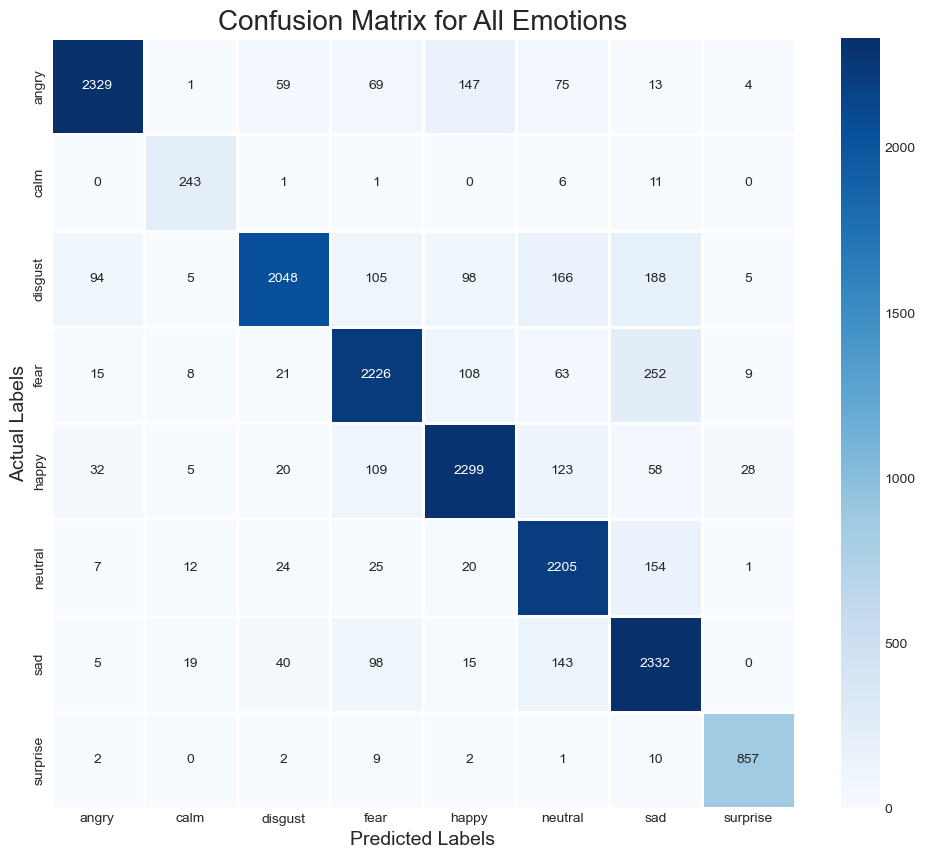

In [25]:
cm = confusion_matrix(y_testall, y_predall)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix for All Emotions', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()